In [1]:
from utils import set_seed
set_seed()

In [2]:
# In your notebook
from model import DiceLoss
from train_utils import train_model, evaluate
from utils import get_model
import torch
from hyperparameter_optimisation import (
    perform_grid_search, 
    perform_bayesian_optimization,
    plot_optimization_comparison,
    plot_hyperparameter_importance
)

# Define the hyperparameter space
param_space = {
    # Model hyperparameters
    'base_filters': [8, 16],
    'depth': [2, 4],
    'bilinear': [True],
    
    # Training hyperparameters
    'learning_rate': [0.00005, 0.0001, 0.001],
    'weight_decay': [1e-6, 1e-5, 1e-4],
    'batch_size': [8, 16, 32],
}

# Define the Bayesian optimization parameter space
bayesian_param_space = {
    # Model hyperparameters
    'base_filters': (8, 16),     # Will be rounded to integer
    'depth': (2, 4),             # Will be rounded to integer
    'bilinear': [True],   # Categorical
    
    # Training hyperparameters
    'learning_rate': (0.00005, 0.005),  # Log scale
    'weight_decay': (1e-6, 1e-4),      # Log scale
    'batch_size': [8, 16, 32]          # Categorical
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:

# Get dataset rather than dataloaders
from dataset import get_datasets

data_dir = 'square_segmentation_dataset/'

# Get datasets
train_dataset, val_dataset, test_dataset = get_datasets(data_dir)

grid_results, grid_best = perform_grid_search(
    param_space=param_space,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    train_model_fn=train_model,
    get_model_fn=get_model,
    criterion_fn=DiceLoss,
    device=device,
    metric='iou_score',
    num_workers=8
)

bayesian_results, bayesian_best, study = perform_bayesian_optimization(
    param_space=bayesian_param_space,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    train_model_fn=train_model,
    get_model_fn=get_model,
    criterion_fn=DiceLoss,
    device=device,
    n_trials=35,
    metric='iou_score',
    seed=42,
    num_workers=10
)

# Compare results
print("\nBest Grid Search Result:")
for k, v in grid_best.items():
    print(f"  {k}: {v}")

print("\nBest Bayesian Optimization Result:")
for k, v in bayesian_best.items():
    print(f"  {k}: {v}")


[I 2025-03-26 14:07:14,111] A new study created in memory with name: no-name-a661b4bb-9e46-4eae-8532-3ca5747f5323


Starting Bayesian optimization with 35 trials


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-03-26 14:07:50,780] Trial 0 finished with value: 0.8752952103591258 and parameters: {'base_filters': 11, 'depth': 4, 'bilinear': True, 'learning_rate': 0.0014553179565665352, 'weight_decay': 1.575132049977973e-05, 'batch_size': 8}. Best is trial 0 with value: 0.8752952103591258.
[I 2025-03-26 14:08:26,290] Trial 1 finished with value: 0.883694353942565 and parameters: {'base_filters': 15, 'depth': 3, 'bilinear': True, 'learning_rate': 0.0013035123791853842, 'weight_decay': 1.0994335574766194e-06, 'batch_size': 8}. Best is trial 1 with value: 0.883694353942565.
[I 2025-03-26 14:09:00,493] Trial 2 finished with value: 0.7960381017519496 and parameters: {'base_filters': 9, 'depth': 2, 'bilinear': True, 'learning_rate': 0.00020298058052421552, 'weight_decay': 1.120760621186056e-05, 'batch_size': 32}. Best is trial 1 with value: 0.883694353942565.
[I 2025-03-26 14:09:31,301] Trial 3 finished with value: 0.8170833170815908 and parameters: {'base_filters': 9, 'depth': 2, 'bilinear': T

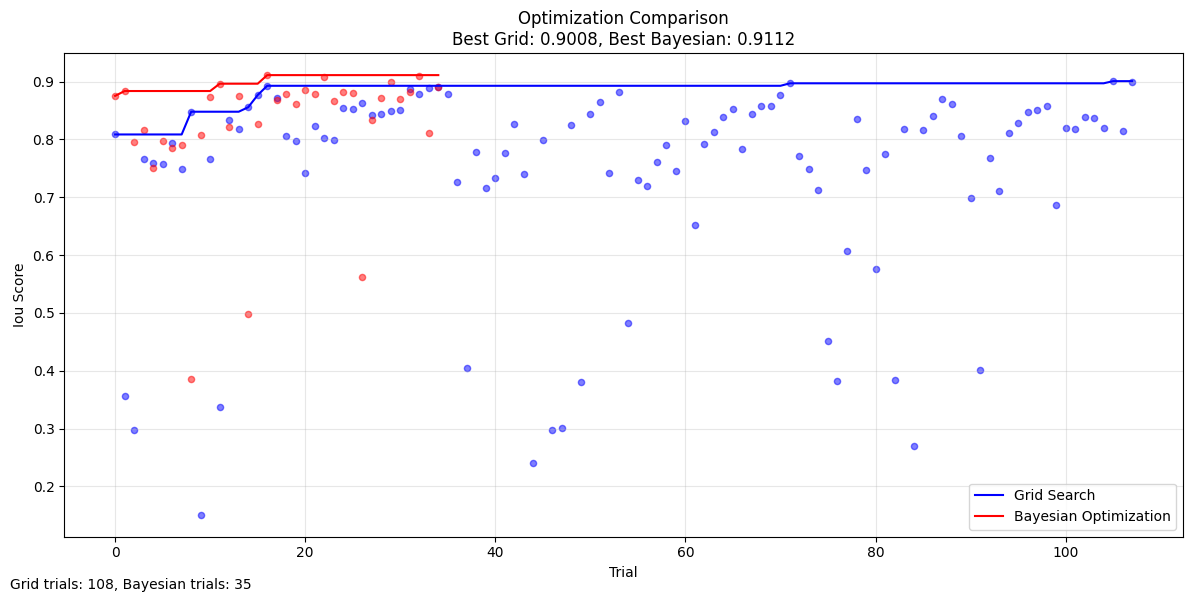

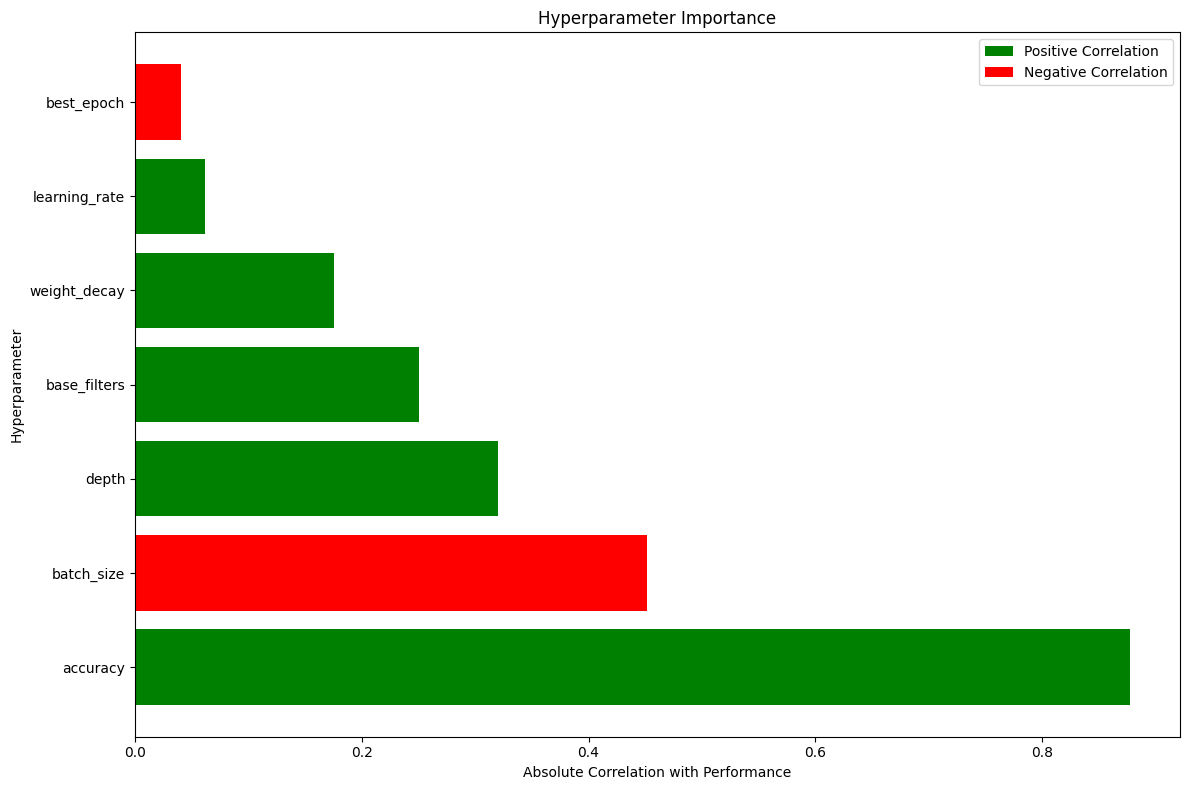

Created data loaders with 210 training, 45 validation, and 45 test samples

Training final model with best hyperparameters...
Epoch [5/100] - Train loss: 0.5402 - Train acc: 0.9727 - Val loss: 0.5094 - Val acc: 0.9799 - Val F1: 0.9397 - Val IoU: 0.8870
Epoch [10/100] - Train loss: 0.4083 - Train acc: 0.9842 - Val loss: 0.3744 - Val acc: 0.9661 - Val F1: 0.9081 - Val IoU: 0.8327
Epoch [15/100] - Train loss: 0.2836 - Train acc: 0.9880 - Val loss: 0.2640 - Val acc: 0.9825 - Val F1: 0.9479 - Val IoU: 0.9014
Epoch [20/100] - Train loss: 0.1999 - Train acc: 0.9872 - Val loss: 0.2131 - Val acc: 0.9673 - Val F1: 0.9103 - Val IoU: 0.8367
Epoch [25/100] - Train loss: 0.1314 - Train acc: 0.9927 - Val loss: 0.1306 - Val acc: 0.9868 - Val F1: 0.9593 - Val IoU: 0.9220
Epoch [30/100] - Train loss: 0.1034 - Train acc: 0.9918 - Val loss: 0.0997 - Val acc: 0.9875 - Val F1: 0.9632 - Val IoU: 0.9297
Epoch [35/100] - Train loss: 0.0711 - Train acc: 0.9946 - Val loss: 0.0982 - Val acc: 0.9832 - Val F1: 0.94

In [7]:

# Visualize comparison
plot_optimization_comparison(grid_results, bayesian_results, metric='iou_score')

# Visualize hyperparameter importance from Bayesian optimization
plot_hyperparameter_importance(bayesian_results, optimized_metric='iou_score')

# Train the final model with the best hyperparameters
best_config = bayesian_best if bayesian_best['iou_score'] > grid_best['iou_score'] else grid_best

model_config = {
    'base_filters': int(best_config['base_filters']),
    'depth': int(best_config['depth']),
    'bilinear': best_config['bilinear']
}

train_config = {
    'learning_rate': best_config['learning_rate'],
    'weight_decay': best_config['weight_decay'],
    'batch_size': int(best_config['batch_size']),
    'num_epochs': 100,  # Train longer for final model
    'patience': 15      # More patience for final model
}

# Initialize model with best hyperparameters
best_model = get_model(model_config, device=device)
criterion = DiceLoss()
optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=train_config['learning_rate'],
    weight_decay=train_config['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

from dataset import get_dataloaders

train_loader, val_loader, test_loader = get_dataloaders(data_dir, num_workers=8, batch_size=train_config['batch_size'], persistent_workers=True, prefetch_factor=2)

# Train final model
print("\nTraining final model with best hyperparameters...")
best_model, history = train_model(
    best_model, train_loader, val_loader, optimizer, criterion,
    scheduler=scheduler, 
    num_epochs=train_config['num_epochs'],
    patience=train_config['patience'],
    device=device
)


In [8]:
# Evaluate on test set
test_metrics = evaluate(best_model, test_loader, criterion, device)
print("\nFinal model test set evaluation:")
for metric, value in test_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Save the best model
from utils import save_model
save_model(best_model, model_config, train_config, history, path="best_bayesian_model.pth")


Final model test set evaluation:
  loss: 0.0507
  accuracy: 0.9855
  f1_score: 0.9551
  iou_score: 0.9147
Model saved to best_bayesian_model.pth


Predictions on test set:


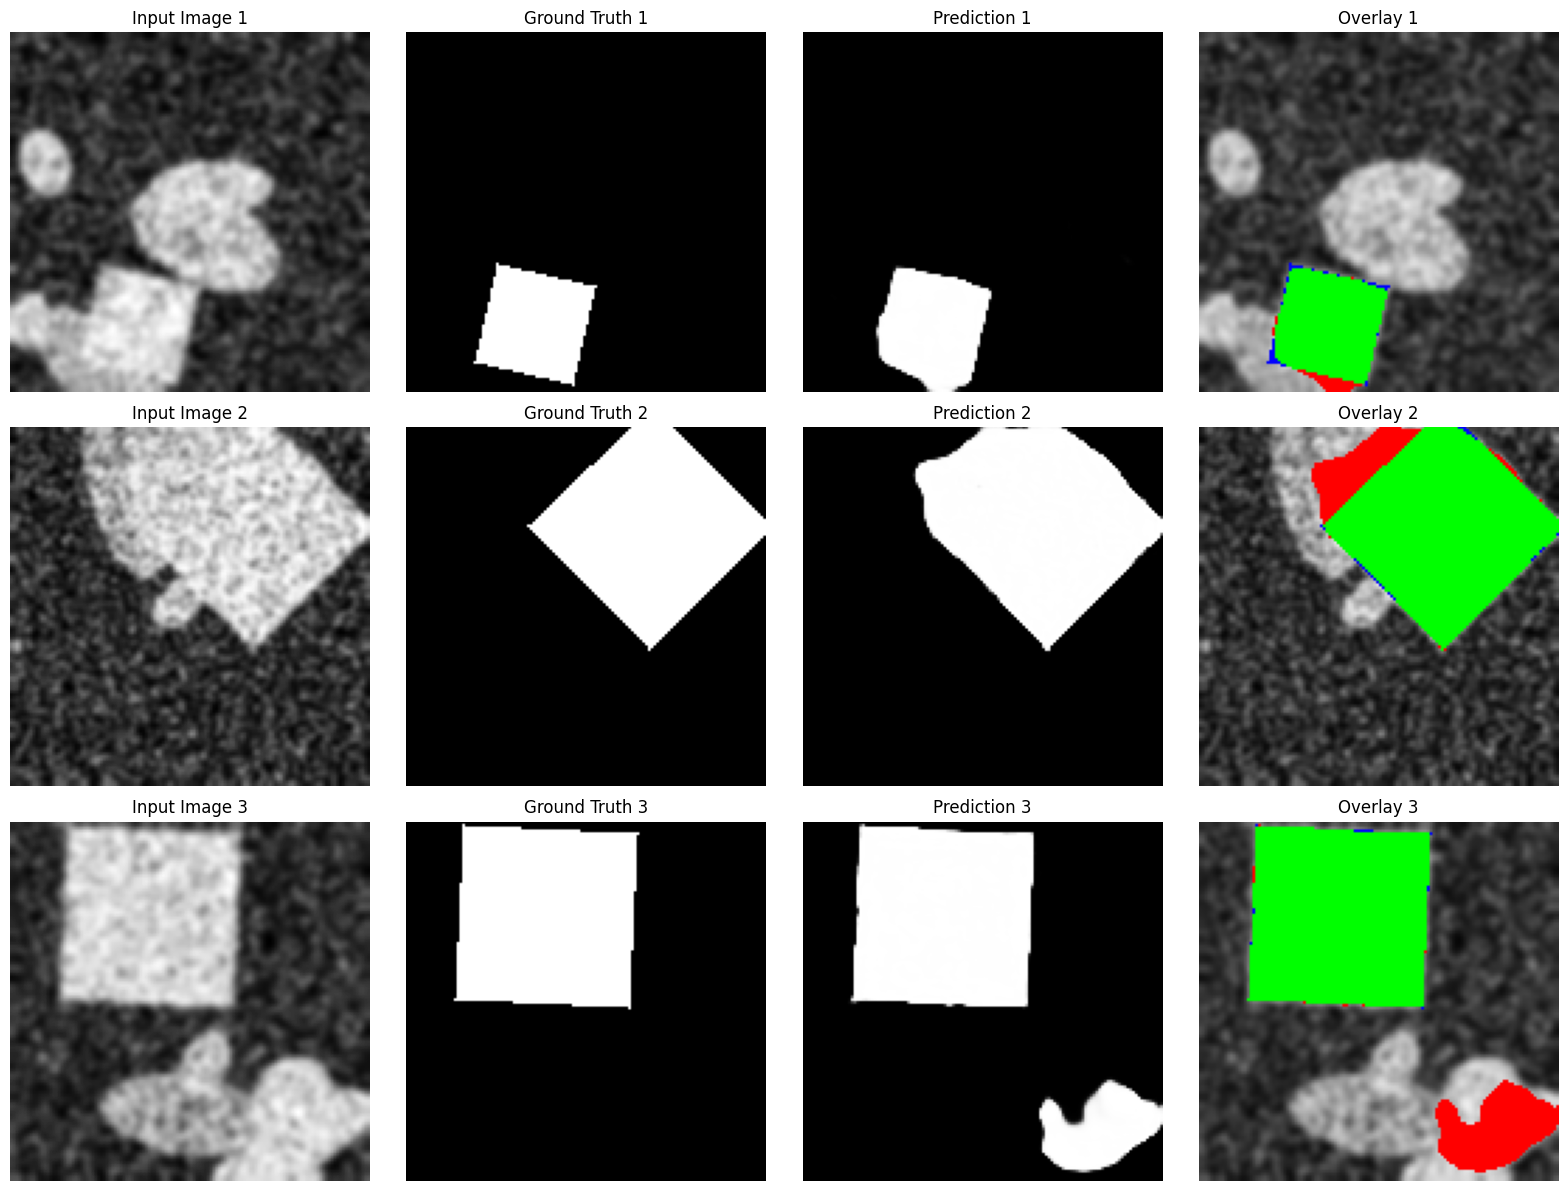

In [11]:
# show predictions using best model
from utils import visualize_predictions
print("Predictions on test set:")
visualize_predictions(best_model, test_loader, device=device)

In [ ]:
# Example training and evaluation code (commented out for clarity)

# from utils import visualize_samples
# from dataset import get_dataloaders

# # Initialize dataloaders
# data_dir = dataset_config['dataset']['path']
# train_loader, val_loader, test_loader = get_dataloaders(data_dir, batch_size=16, num_workers=6, persistent_workers=True, prefetch_factor=2)

# # Display dataset sizes
# print(f"Train samples: {len(train_loader.dataset)}")
# print(f"Validation samples: {len(val_loader.dataset)}")
# print(f"Test samples: {len(test_loader.dataset)}")


# # Visualize training samples
# # print("Training samples:")
# visualize_samples(train_loader)

# from utils import get_model, test_model
# model_config = {
#     'base_filters': 16,
#     'bilinear': True,
#     'depth': 3
# }

# # Initialize and test model
# model = get_model(model_config, device=device)
# test_model(model, device=device)
# from train_utils import train_model
# from model import DiceLoss

# train_config = {
#     'learning_rate': 0.0005,
#     'weight_decay': 1e-5,
#     'batch_size': 16,
#     'num_epochs': 50,
#     'patience': 10
# }

# # Initialize optimizer, loss and scheduler
# model = get_model(model_config, device=device)
# criterion = DiceLoss()
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=train_config['learning_rate'],
#     weight_decay=train_config['weight_decay']
# )
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=5, verbose=True
# )

# # Train model
# print("Starting training...")
# model, history = train_model(
#     model, train_loader, val_loader, optimizer, criterion,
#     scheduler=scheduler, 
#     num_epochs=train_config['num_epochs'],
#     patience=train_config['patience'],
#     device=device
# )
# from utils import plot_history
# plot_history(history)
# from train_utils import evaluate 
# from utils import visualize_predictions

# test_metrics = evaluate(model, test_loader, criterion, device)
# print("Test set evaluation:")
# for metric, value in test_metrics.items():
#     print(f"  {metric}: {value:.4f}")

# # Visualize predictions
# print("Predictions on test set:")
# visualize_predictions(model, test_loader, device=device)
# from utils import save_model, load_model

# # Save trained model
# save_model(model, model_config, train_config, history)

# print("Training and evaluation complete!")